<a href="https://colab.research.google.com/github/MarcAstner/Dig-Bata/blob/master/Astrophysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery

     |████████████████████████████████| 4.5MB 4.9MB/s 
     |████████████████████████████████| 2.3MB 34.9MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=69365085a4b45255373622346c55ff74d27d11570c6efefd6da14bddfb07edf1
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
Successfully built astroquery


In [0]:
# For querying for data
import requests
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u

import re

# For matplotlib plotting
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
plotting.output_notebook()

In [3]:
weird_tic_id = "100029948"

exomast_url = "https://exo.mast.stsci.edu/api/v0.1/"

list_tce_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/tces/"
list_tce_query

response = requests.get(list_tce_query)
tce_dict = response.json()
print(tce_dict)

weird_sector, weird_tce = tce_dict['TCE'][0].split(":")

dv_metadata_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/info/?tce={weird_tce}&sector={weird_sector}"
dv_metadata_query

response = requests.get(dv_metadata_query)
metadata = response.json()
metadata.keys()

metadata['DV Primary Header'].keys()

metadata['DV Data Header'].keys()



{'TCE': ['s0001-s0003:TCE_1', 's0002-s0002:TCE_1', 's0003-s0003:TCE_2', 's0001-s0003:TCE_3', 's0003-s0003:TCE_1', 's0001-s0003:TCE_2']}


dict_keys(['TICID', 'EXTNAME', 'EXTVER', 'SIMDATA', 'RADESYS', 'RA_OBJ', 'DEC_OBJ', 'EQUINOX', 'EXPOSURE', 'TIMEREF', 'TASSIGN', 'TIMESYS', 'BJDREFI', 'BJDREFF', 'TIMEUNIT', 'TELAPSE', 'LIVETIME', 'TSTART', 'TSTOP', 'DATE_OBS', 'DATE_END', 'DEADC', 'TIMEPIXR', 'TIERRELA', 'INT_TIME', 'READTIME', 'FRAMETIM', 'NUM_FRM', 'TIMEDEL', 'TPERIOD', 'TEPOCH', 'TDEPTH', 'TSNR', 'TDUR', 'INDUR', 'IMPACT', 'INCLIN', 'DRRATIO', 'RADRATIO', 'PRADIUS', 'MAXMES', 'MAXSES', 'NTRANS', 'CONVRGE', 'MEDDETR', 'TESSDatetime', 'SECTORS'])

In [4]:
dv_lightcurve_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/table/?tce={weird_tce}&sector={weird_sector}"
dv_lightcurve_query

response = requests.get(dv_lightcurve_query)
data_dict = response.json()
data_dict.keys()

for col in data_dict['fields']:
    print(f"{col['colname']} {col['datatype']:5} {col['description']}")

TIME                float  column title: data time stamps
TIMECORR            real   column title: barycenter - timeslice correction
CADENCENO           int    column title: unique cadence number
PHASE               real   column title: Phase using period and epoch
LC_INIT             real   column title: Detrended initial light curve (ga
LC_INIT_ERR         real   column title: Error in the detrended initial li
LC_WHITE            real   column title: Initial whitened time series fit
LC_DETREND          real   column title: Initial median detrended time ser
MODEL_INIT          real   column title: Model light curve
MODEL_WHITE         real   column title: Whitened model light curve


In [0]:
def json_to_table(fields, data):
    """"
    Takes a json object and turns it into an astropy table.

    Parameters
    ----------
    fields : list of dicts
        Of the form [{colname:,datatype:,description:}, ...]
    data : list of dicts
       Of the form [{col1:, col2:, ...},{col1:, col2:, ...}, ...]

    Returns
    -------
    response : `astropy.table.Table`
    """

    rx = re.compile(r"varchar\((\d+)\)")
    
    data_table = Table()

    for col, atype in [(x['colname'], x['datatype']) for x in fields]:
        col = col.strip()
        if "varchar" in atype:
            match = rx.search(atype)
            atype = "U" + match.group(1)
        if atype == "real":
            atype = "float"
        data_table[col] = np.array([x.get(col, None) for x in data], dtype=atype)

    return data_table

In [6]:
weird_lightcurve = json_to_table(data_dict['fields'],data_dict['data'])
weird_lightcurve

TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1354.1060809949213,0.0033908600453287363,91186,-0.06769520044326782,nan,nan,nan,nan,nan,nan
1354.107469928346,0.003390904748812318,91187,-0.06630627065896988,nan,nan,nan,nan,nan,nan
1354.1088588617658,0.003390949685126543,91188,-0.06491733342409134,nan,nan,nan,nan,nan,nan
1354.1102477951827,0.0033909946214407682,91189,-0.0635284036397934,nan,nan,nan,nan,nan,nan
1354.111636728596,0.0033910395577549934,91190,-0.062139470130205154,nan,nan,nan,nan,nan,nan
1354.1130256620056,0.003391084261238575,91191,-0.06075053662061691,-0.05790769308805466,0.0027607246302068233,nan,-0.05790769308805466,nan,nan
1354.114414595411,0.0033911291975528,91192,-0.05936160311102867,-0.06443305313587189,0.002758975373581052,nan,-0.06443305313587189,nan,nan
1354.115803528811,0.0033911739010363817,91193,-0.05797266960144043,nan,nan,nan,nan,nan,nan
1354.117192462208,0.003391218837350607,91194,-0.05658373609185219,-0.08467519283294678,0.00274289445951581,nan,-0.08467519283294678,nan,nan


In [7]:
ra = metadata['DV Data Header']['RA_OBJ']
dec = metadata['DV Data Header']['DEC_OBJ']
obj_coord = SkyCoord(ra,dec,unit="deg")
print(obj_coord)

Tesscut.get_sectors(obj_coord)

cutout_hdu = Tesscut.get_cutouts(obj_coord, size=50)[0]

cutout_hdu.info()

cutout_table = cutout_hdu[1].data
cutout_table.columns

<SkyCoord (ICRS): (ra, dec) in deg
    (23.426279, -43.823121)>
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 2500J, 2500E, 2500E, 2500E, 2500E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (50, 50)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '2500J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(50, 50)'
    name = 'FLUX'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_BKG'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_BKG_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

In [8]:
bfig = plotting.figure(plot_width=850, plot_height=250, title=f"Detrended Lightcurve (TIC{weird_tic_id})")
bfig.circle(weird_lightcurve["TIME"],weird_lightcurve["LC_DETREND"], fill_color="black",size=1, line_color=None)
plotting.show(bfig)


The detrended lightcurve shows the periodicity of the planet's orbit


In [9]:
def find_index(btjd):
    """
    Given a time as a Barycentric TESS Julian Date (BTJD) timestamp, return the closest index in a table
    that is assumed to have a TIME column that is also in BTJD"""
    
    return (np.abs(cutout_table['TIME'] - btjd)).argmin()

start = find_index(1354.8)
end = find_index(1355.8)

print(f"Frames {start}-{end} ({end-start} frames)")

Frames 33-81 (48 frames)


In [0]:
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani


In [11]:
make_animation(cutout_table['FLUX'], start, end, vmax = 500)


The change in flux could be related to exoplanet orbiting or a variable star.

Number of sources: 7
    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
100029948 23.4263049755405 -43.8231097019207 ...      0                0.0
100029942 23.4739158302872 -43.7944727029683 ...      0 161.02058151680686
100029967 23.3612632659429 -43.9012790650104 ...      0  328.1661649375571
100031500 23.5555576457142 -43.8342932897934 ...      0 338.08635164322266
100031483 23.5313857571239 -43.9288372717088 ...      0 468.21958764649304
100029974  23.375855683165 -43.9601629045309 ...      0  510.4562075283514
100029913 23.3401029995552 -43.6776623318287 ...      0  569.5779415393152


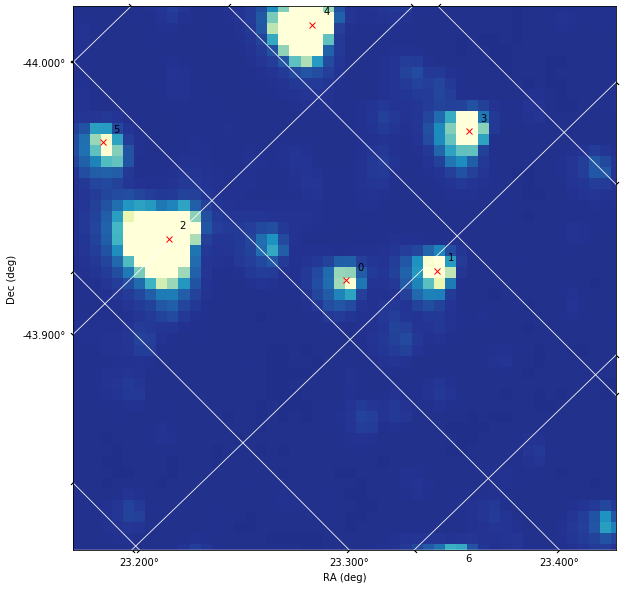

In [13]:
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {weird_tic_id}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}")
print(sources)

cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start]

fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

In [26]:
sources["ID","ra","dec"][0]

variable_tic_id = sources["ID"][0]

variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

Number of tasoc light curves for 100029948: 2

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00100029948-s02-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00100029948-s02-c0120_tess_v04_lc.fits with expected size 1823040. [astroquery.query]


In [30]:
hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})")

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

On a second look one can see two periodical changes in flux. This might also indicate a binary star system.

In [31]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["FLUX_RAW"])
frequency, power = lomb.autopower(maximum_frequency=5)

dominant_freq = frequency[np.argmax(power)].value
print(f"The dominant priod: {1/dominant_freq*24:.3} hours")

bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})")

# Plotting the phased light curve
bfig.circle(variable_lc["TIME"]%(1/dominant_freq),variable_lc["FLUX_RAW"], fill_color="black",size=1, line_color=None)

# Plotting the periodic fit
t_fit = np.linspace(0,1/dominant_freq,1)
bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color='#1b9f00', line_width=0.5)

# Labeling the axes
bfig.xaxis.axis_label = "Phase (days)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

The dominant priod: 6.58e+03 hours


Due to not having TESS look at one part of the sky during the whole mission we will get holes in our data. Though we got enough data to analize this star system.
